In [2]:
pip install tpot

     |████████████████████████████████| 87 kB 8.7 MB/s             
     |████████████████████████████████| 160 kB 58.2 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=495df24ee48ec71c657fe1266f61f492fcf713c5061477fb4536afa6e11e9fb2
  Stored in directory: /home/datalore/.cache/pip/wheels/a8/bb/8f/6b9328d23c2dcedbfeb8498b9f650d55d463089e3b8fc0bfb2
Successfully built stopit
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn import model_selection
import seaborn as sns
import random
from sklearn.model_selection import KFold

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

In [2]:



# NOTE: Make sure that the outcome column is labeled 'target' in the data file
filename = "YieldStress_database.csv"
file_stats_name = "framework_stats.csv"
target_feature = "YS (MPa)"
data_df = pd.read_csv(filename)
data_df = data_df.iloc[:, 1:]
tpot_data = data_df
features = tpot_data.drop(target_feature, axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data[target_feature], random_state=1331)

# Average CV score on the training set was: -256.0447252776591
exported_pipeline = make_pipeline(
    StandardScaler(),
    StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, 
    loss="ls", max_depth=6, max_features=0.15000000000000002, min_samples_leaf=3, 
    min_samples_split=15, n_estimators=100, subsample=0.6000000000000001)),
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True, max_features=0.15000000000000002, 
    min_samples_leaf=4, min_samples_split=2, n_estimators=100)),
    RandomForestRegressor(bootstrap=True, max_features=0.3, min_samples_leaf=4, 
                          min_samples_split=6, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 1331)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

/opt/python/envs/default/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [4]:
r2 = r2_score(testing_target,results)
MAE = mean_absolute_error(testing_target,results)
MSE = mean_squared_error(testing_target,results)
print("r2: " + str(r2))
print("MAE: " + str(MAE))
print("MSE: " + str(MSE))






    




r2: 0.5349709915486405
MAE: 270.70748757700994
MSE: 186816.47986304178


In [9]:


best_model = exported_pipeline.steps[-1][1]
feature_names = training_features.columns
feature_importance = best_model.feature_importances_
# sorted_idx = np.argsort(feature_importance)
# pos = np.arange(sorted_idx.shape[0]) + 0.5
# plt.barh(pos, feature_importance[sorted_idx], align="center")
# plt.yticks(pos, np.array(feature_names)[sorted_idx])
# plt.title("Feature Importance (MDI) of Model ")

# result = permutation_importance(
#     best_model, testing_features, testing_target, n_repeats=10, random_state=13, n_jobs=2
# )
# sorted_idx = result.importances_mean.argsort()
# plt.boxplot(
#     result.importances[sorted_idx].T,
#     vert=False,
#     labels=np.array(feature_names)[sorted_idx],
# )
# plt.title("Permutation Importance (test set)")
# fig.tight_layout()
# plt.show()

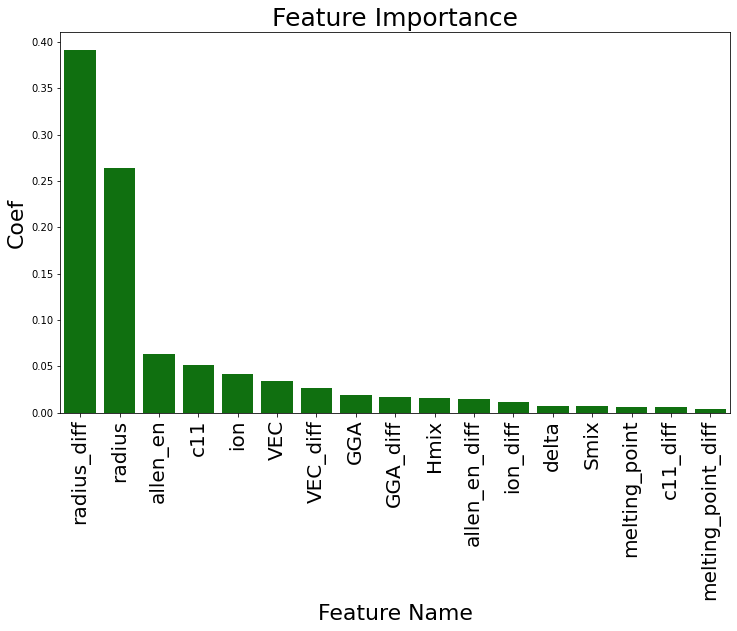

In [11]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, feature_importance)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Feature Importance", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)